In [48]:
from __future__ import unicode_literals, print_function, division
import torch
import torch.nn as nn

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.insert(0, '../preprocessing/') #need this in order to get to the other file in other directory

#can comment out the ones you aren't using to save a little bit of time
from covidPreprocess import getCoronaVocabulary, getCoronaText
from liarPreprocess import getLiarVocabulary, getLiarText
from fnnPreprocess import getFNNVocabulary, getFNNText

In [2]:
class SimpleNeuralNet(nn.Module):

    def __init__(self, input_size, hidden_size, num_classes):
        super(SimpleNeuralNet, self).__init__()
        #Written based off of the tutorial at
        #https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/01-basics/feedforward_neural_network/main.py#L37-L49
        self.hidden1 = nn.Linear(input_size, hidden_size) 
        self.relu = nn.ReLU()   
        self.hOutput1 = nn.Linear(hidden_size, num_classes)  
        self.softmax = nn.Softmax(dim = 0)

    def forward(self, x):
        out = self.hidden1(x)
        out = self.relu(out)
        out = self.hOutput1(out)
        out = self.softmax(out)
        return out

In [35]:
def trainAndTestSimpleModel(dataset: str, num_epochs = 5, learning_rate = 0.001, print_epoch_mod = 5):
    '''
    gets around 63-71% for corona and Liar datasets, around 80-83% on FNN
    
    used this article for help in writing the tensor parts of code so it works with the model
    https://medium.com/analytics-vidhya/part-1-sentiment-analysis-in-pytorch-82b35edb40b8
    '''
    torch.manual_seed(1)
    if dataset == 'corona':
        X,Y = getCoronaText() #this function will give us the text array (not document term matrix) and Y
        X_train,Y_train, vectorizer_train = getCoronaVocabulary(True)
    elif dataset == 'liar':
        X,Y = getLiarText()
        X_train,Y_train, vectorizer_train = getLiarVocabulary(True)
    elif dataset == 'fnn':
        X,Y = getFNNText()
        X_train,Y_train, vectorizer_train = getFNNVocabulary(True)
    
    #transform our testing dataset to match the vocabulary for the training dataset
    #transform will return the document-term matrix for X based on training dataset
    x_test = vectorizer_train.transform(X)
    
    #sample test on logistic classifier
    '''classifier = LogisticRegression()
    classifier.fit(X_train,Y_train)
    score = classifier.score(x_test,Y)
    print(score)'''
    
    vocabsize = X_train.shape[1]
    
    
    #transform our training and test data into tensors for the classifier to learn off of
    X_tensor = torch.from_numpy(X_train.todense()).float()
    Y_tensor = torch.from_numpy(np.array(Y_train))
    
    X_test_tensor = torch.from_numpy(x_test.todense()).float()
    Y_test_tensor = torch.from_numpy(np.array(Y))
    
    device = torch.device('cpu')
    #use TensorDataset to be able to use our DataLoader
    train_data = torch.utils.data.TensorDataset(X_tensor, Y_tensor)
#     train_loader = torch.utils.data.DataLoader(train_data,batch_size=16, shuffle=True)
    train_loader = torch.utils.data.DataLoader(train_data,batch_size=16, shuffle=False)
    
    test_data = torch.utils.data.TensorDataset(X_test_tensor, Y_test_tensor)
#     test_loader = torch.utils.data.DataLoader(test_data,batch_size=16, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_data,batch_size=16, shuffle=False)
    
    #initialize our model
    model = SimpleNeuralNet(vocabsize, 200, 2).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    
    
    total_step = len(train_loader)
    for epoch in range(num_epochs):
        for i, (x_batch, labels) in enumerate(train_loader):
    
            # Forward pass
            # The forward process computes the loss of each iteration on each sample
            model.train()
            y_pred = model(x_batch)
            #need to transform labels to long datatype using .long() or it complains it's an int
            loss = criterion(y_pred, labels.long())
    
            # Backward pass, using the optimizer to update the parameters
            optimizer.zero_grad()
            loss.backward()    #compute gradients
            optimizer.step()   #initiate gradient descent
    
     
            # Below, an epoch corresponds to one pass through all of the samples.
            # Each training step corresponds to a parameter update using 
            # a gradient computed on a minibatch of 100 samples 
            if (i + 1) % print_epoch_mod == 0: 
                #leaving it on 5 for corona dataset, probably want to change to % 50 or % 100
                # for the other datasets so don't get spammed 
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                      .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))
    
    # Test the model
    # In the test phase, we don't need to compute gradients (the model has already been learned)
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        print('Test accuracy of the network: {} %'.format(100 * correct / total))
        test_accuracy = 100 * correct / total
        
    # Print out training accuracy
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in train_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        print('Train accuracy of the network: {} %'.format(100 * correct / total))
        train_accuracy = 100 * correct / total
    
    return test_accuracy, train_accuracy

In [36]:
test_accuracies = []
train_accuracies = []

In [37]:
test_accuracy, train_accuracy = trainAndTestSimpleModel('corona', num_epochs=5)
test_accuracies.append(test_accuracy)
train_accuracies.append(train_accuracy)


Extracting tokens....
there are 70 nan titles
there are 9 nan text

Extracting tokens....
there are 12 nan titles
there are 1 nan text
Data shape for text:  (291, 7417)
Epoch [1/5], Step [5/19], Loss: 0.6801
Epoch [1/5], Step [10/19], Loss: 0.6651
Epoch [1/5], Step [15/19], Loss: 0.6412
Epoch [2/5], Step [5/19], Loss: 0.6423
Epoch [2/5], Step [10/19], Loss: 0.6454
Epoch [2/5], Step [15/19], Loss: 0.6420
Epoch [3/5], Step [5/19], Loss: 0.6454
Epoch [3/5], Step [10/19], Loss: 0.6450
Epoch [3/5], Step [15/19], Loss: 0.6443
Epoch [4/5], Step [5/19], Loss: 0.6441
Epoch [4/5], Step [10/19], Loss: 0.6418
Epoch [4/5], Step [15/19], Loss: 0.6399
Epoch [5/5], Step [5/19], Loss: 0.6408
Epoch [5/5], Step [10/19], Loss: 0.6418
Epoch [5/5], Step [15/19], Loss: 0.6444
Test accuracy of the network: 65.75028636884306 %
Train accuracy of the network: 76.97594501718213 %


In [38]:
test_accuracy, train_accuracy = trainAndTestSimpleModel('corona', num_epochs=10)
test_accuracies.append(test_accuracy)
train_accuracies.append(train_accuracy)


Extracting tokens....
there are 70 nan titles
there are 9 nan text

Extracting tokens....
there are 12 nan titles
there are 1 nan text
Data shape for text:  (291, 7417)
Epoch [1/10], Step [5/19], Loss: 0.6801
Epoch [1/10], Step [10/19], Loss: 0.6651
Epoch [1/10], Step [15/19], Loss: 0.6412
Epoch [2/10], Step [5/19], Loss: 0.6423
Epoch [2/10], Step [10/19], Loss: 0.6454
Epoch [2/10], Step [15/19], Loss: 0.6420
Epoch [3/10], Step [5/19], Loss: 0.6454
Epoch [3/10], Step [10/19], Loss: 0.6450
Epoch [3/10], Step [15/19], Loss: 0.6443
Epoch [4/10], Step [5/19], Loss: 0.6441
Epoch [4/10], Step [10/19], Loss: 0.6418
Epoch [4/10], Step [15/19], Loss: 0.6399
Epoch [5/10], Step [5/19], Loss: 0.6408
Epoch [5/10], Step [10/19], Loss: 0.6418
Epoch [5/10], Step [15/19], Loss: 0.6444
Epoch [6/10], Step [5/19], Loss: 0.6413
Epoch [6/10], Step [10/19], Loss: 0.6404
Epoch [6/10], Step [15/19], Loss: 0.6418
Epoch [7/10], Step [5/19], Loss: 0.6445
Epoch [7/10], Step [10/19], Loss: 0.6443
Epoch [7/10], Ste

In [39]:
test_accuracy, train_accuracy = trainAndTestSimpleModel('corona', num_epochs=20)
test_accuracies.append(test_accuracy)
train_accuracies.append(train_accuracy)


Extracting tokens....
there are 70 nan titles
there are 9 nan text

Extracting tokens....
there are 12 nan titles
there are 1 nan text
Data shape for text:  (291, 7417)
Epoch [1/20], Step [5/19], Loss: 0.6801
Epoch [1/20], Step [10/19], Loss: 0.6651
Epoch [1/20], Step [15/19], Loss: 0.6412
Epoch [2/20], Step [5/19], Loss: 0.6423
Epoch [2/20], Step [10/19], Loss: 0.6454
Epoch [2/20], Step [15/19], Loss: 0.6420
Epoch [3/20], Step [5/19], Loss: 0.6454
Epoch [3/20], Step [10/19], Loss: 0.6450
Epoch [3/20], Step [15/19], Loss: 0.6443
Epoch [4/20], Step [5/19], Loss: 0.6441
Epoch [4/20], Step [10/19], Loss: 0.6418
Epoch [4/20], Step [15/19], Loss: 0.6399
Epoch [5/20], Step [5/19], Loss: 0.6408
Epoch [5/20], Step [10/19], Loss: 0.6418
Epoch [5/20], Step [15/19], Loss: 0.6444
Epoch [6/20], Step [5/19], Loss: 0.6413
Epoch [6/20], Step [10/19], Loss: 0.6404
Epoch [6/20], Step [15/19], Loss: 0.6418
Epoch [7/20], Step [5/19], Loss: 0.6445
Epoch [7/20], Step [10/19], Loss: 0.6443
Epoch [7/20], Ste

In [40]:
test_accuracy, train_accuracy = trainAndTestSimpleModel('corona', num_epochs=30)
test_accuracies.append(test_accuracy)
train_accuracies.append(train_accuracy)


Extracting tokens....
there are 70 nan titles
there are 9 nan text

Extracting tokens....
there are 12 nan titles
there are 1 nan text
Data shape for text:  (291, 7417)
Epoch [1/30], Step [5/19], Loss: 0.6801
Epoch [1/30], Step [10/19], Loss: 0.6651
Epoch [1/30], Step [15/19], Loss: 0.6412
Epoch [2/30], Step [5/19], Loss: 0.6423
Epoch [2/30], Step [10/19], Loss: 0.6454
Epoch [2/30], Step [15/19], Loss: 0.6420
Epoch [3/30], Step [5/19], Loss: 0.6454
Epoch [3/30], Step [10/19], Loss: 0.6450
Epoch [3/30], Step [15/19], Loss: 0.6443
Epoch [4/30], Step [5/19], Loss: 0.6441
Epoch [4/30], Step [10/19], Loss: 0.6418
Epoch [4/30], Step [15/19], Loss: 0.6399
Epoch [5/30], Step [5/19], Loss: 0.6408
Epoch [5/30], Step [10/19], Loss: 0.6418
Epoch [5/30], Step [15/19], Loss: 0.6444
Epoch [6/30], Step [5/19], Loss: 0.6413
Epoch [6/30], Step [10/19], Loss: 0.6404
Epoch [6/30], Step [15/19], Loss: 0.6418
Epoch [7/30], Step [5/19], Loss: 0.6445
Epoch [7/30], Step [10/19], Loss: 0.6443
Epoch [7/30], Ste

In [41]:
test_accuracy, train_accuracy = trainAndTestSimpleModel('corona', num_epochs=40)
test_accuracies.append(test_accuracy)
train_accuracies.append(train_accuracy)


Extracting tokens....
there are 70 nan titles
there are 9 nan text

Extracting tokens....
there are 12 nan titles
there are 1 nan text
Data shape for text:  (291, 7417)
Epoch [1/40], Step [5/19], Loss: 0.6801
Epoch [1/40], Step [10/19], Loss: 0.6651
Epoch [1/40], Step [15/19], Loss: 0.6412
Epoch [2/40], Step [5/19], Loss: 0.6423
Epoch [2/40], Step [10/19], Loss: 0.6454
Epoch [2/40], Step [15/19], Loss: 0.6420
Epoch [3/40], Step [5/19], Loss: 0.6454
Epoch [3/40], Step [10/19], Loss: 0.6450
Epoch [3/40], Step [15/19], Loss: 0.6443
Epoch [4/40], Step [5/19], Loss: 0.6441
Epoch [4/40], Step [10/19], Loss: 0.6418
Epoch [4/40], Step [15/19], Loss: 0.6399
Epoch [5/40], Step [5/19], Loss: 0.6408
Epoch [5/40], Step [10/19], Loss: 0.6418
Epoch [5/40], Step [15/19], Loss: 0.6444
Epoch [6/40], Step [5/19], Loss: 0.6413
Epoch [6/40], Step [10/19], Loss: 0.6404
Epoch [6/40], Step [15/19], Loss: 0.6418
Epoch [7/40], Step [5/19], Loss: 0.6445
Epoch [7/40], Step [10/19], Loss: 0.6443
Epoch [7/40], Ste

In [42]:
test_accuracy, train_accuracy = trainAndTestSimpleModel('corona', num_epochs=50)
test_accuracies.append(test_accuracy)
train_accuracies.append(train_accuracy)


Extracting tokens....
there are 70 nan titles
there are 9 nan text

Extracting tokens....
there are 12 nan titles
there are 1 nan text
Data shape for text:  (291, 7417)
Epoch [1/50], Step [5/19], Loss: 0.6801
Epoch [1/50], Step [10/19], Loss: 0.6651
Epoch [1/50], Step [15/19], Loss: 0.6412
Epoch [2/50], Step [5/19], Loss: 0.6423
Epoch [2/50], Step [10/19], Loss: 0.6454
Epoch [2/50], Step [15/19], Loss: 0.6420
Epoch [3/50], Step [5/19], Loss: 0.6454
Epoch [3/50], Step [10/19], Loss: 0.6450
Epoch [3/50], Step [15/19], Loss: 0.6443
Epoch [4/50], Step [5/19], Loss: 0.6441
Epoch [4/50], Step [10/19], Loss: 0.6418
Epoch [4/50], Step [15/19], Loss: 0.6399
Epoch [5/50], Step [5/19], Loss: 0.6408
Epoch [5/50], Step [10/19], Loss: 0.6418
Epoch [5/50], Step [15/19], Loss: 0.6444
Epoch [6/50], Step [5/19], Loss: 0.6413
Epoch [6/50], Step [10/19], Loss: 0.6404
Epoch [6/50], Step [15/19], Loss: 0.6418
Epoch [7/50], Step [5/19], Loss: 0.6445
Epoch [7/50], Step [10/19], Loss: 0.6443
Epoch [7/50], Ste

In [43]:
test_accuracy, train_accuracy = trainAndTestSimpleModel('corona', num_epochs=60)
test_accuracies.append(test_accuracy)
train_accuracies.append(train_accuracy)


Extracting tokens....
there are 70 nan titles
there are 9 nan text

Extracting tokens....
there are 12 nan titles
there are 1 nan text
Data shape for text:  (291, 7417)
Epoch [1/60], Step [5/19], Loss: 0.6801
Epoch [1/60], Step [10/19], Loss: 0.6651
Epoch [1/60], Step [15/19], Loss: 0.6412
Epoch [2/60], Step [5/19], Loss: 0.6423
Epoch [2/60], Step [10/19], Loss: 0.6454
Epoch [2/60], Step [15/19], Loss: 0.6420
Epoch [3/60], Step [5/19], Loss: 0.6454
Epoch [3/60], Step [10/19], Loss: 0.6450
Epoch [3/60], Step [15/19], Loss: 0.6443
Epoch [4/60], Step [5/19], Loss: 0.6441
Epoch [4/60], Step [10/19], Loss: 0.6418
Epoch [4/60], Step [15/19], Loss: 0.6399
Epoch [5/60], Step [5/19], Loss: 0.6408
Epoch [5/60], Step [10/19], Loss: 0.6418
Epoch [5/60], Step [15/19], Loss: 0.6444
Epoch [6/60], Step [5/19], Loss: 0.6413
Epoch [6/60], Step [10/19], Loss: 0.6404
Epoch [6/60], Step [15/19], Loss: 0.6418
Epoch [7/60], Step [5/19], Loss: 0.6445
Epoch [7/60], Step [10/19], Loss: 0.6443
Epoch [7/60], Ste

In [44]:
test_accuracy, train_accuracy = trainAndTestSimpleModel('corona', num_epochs=75)
test_accuracies.append(test_accuracy)
train_accuracies.append(train_accuracy)


Extracting tokens....
there are 70 nan titles
there are 9 nan text

Extracting tokens....
there are 12 nan titles
there are 1 nan text
Data shape for text:  (291, 7417)
Epoch [1/75], Step [5/19], Loss: 0.6801
Epoch [1/75], Step [10/19], Loss: 0.6651
Epoch [1/75], Step [15/19], Loss: 0.6412
Epoch [2/75], Step [5/19], Loss: 0.6423
Epoch [2/75], Step [10/19], Loss: 0.6454
Epoch [2/75], Step [15/19], Loss: 0.6420
Epoch [3/75], Step [5/19], Loss: 0.6454
Epoch [3/75], Step [10/19], Loss: 0.6450
Epoch [3/75], Step [15/19], Loss: 0.6443
Epoch [4/75], Step [5/19], Loss: 0.6441
Epoch [4/75], Step [10/19], Loss: 0.6418
Epoch [4/75], Step [15/19], Loss: 0.6399
Epoch [5/75], Step [5/19], Loss: 0.6408
Epoch [5/75], Step [10/19], Loss: 0.6418
Epoch [5/75], Step [15/19], Loss: 0.6444
Epoch [6/75], Step [5/19], Loss: 0.6413
Epoch [6/75], Step [10/19], Loss: 0.6404
Epoch [6/75], Step [15/19], Loss: 0.6418
Epoch [7/75], Step [5/19], Loss: 0.6445
Epoch [7/75], Step [10/19], Loss: 0.6443
Epoch [7/75], Ste

In [45]:
test_accuracy, train_accuracy = trainAndTestSimpleModel('corona', num_epochs=100)
test_accuracies.append(test_accuracy)
train_accuracies.append(train_accuracy)


Extracting tokens....
there are 70 nan titles
there are 9 nan text

Extracting tokens....
there are 12 nan titles
there are 1 nan text
Data shape for text:  (291, 7417)
Epoch [1/100], Step [5/19], Loss: 0.6801
Epoch [1/100], Step [10/19], Loss: 0.6651
Epoch [1/100], Step [15/19], Loss: 0.6412
Epoch [2/100], Step [5/19], Loss: 0.6423
Epoch [2/100], Step [10/19], Loss: 0.6454
Epoch [2/100], Step [15/19], Loss: 0.6420
Epoch [3/100], Step [5/19], Loss: 0.6454
Epoch [3/100], Step [10/19], Loss: 0.6450
Epoch [3/100], Step [15/19], Loss: 0.6443
Epoch [4/100], Step [5/19], Loss: 0.6441
Epoch [4/100], Step [10/19], Loss: 0.6418
Epoch [4/100], Step [15/19], Loss: 0.6399
Epoch [5/100], Step [5/19], Loss: 0.6408
Epoch [5/100], Step [10/19], Loss: 0.6418
Epoch [5/100], Step [15/19], Loss: 0.6444
Epoch [6/100], Step [5/19], Loss: 0.6413
Epoch [6/100], Step [10/19], Loss: 0.6404
Epoch [6/100], Step [15/19], Loss: 0.6418
Epoch [7/100], Step [5/19], Loss: 0.6445
Epoch [7/100], Step [10/19], Loss: 0.64

In [46]:
num_epochs_used = [5, 10, 20, 30, 40, 50, 60, 75, 100]

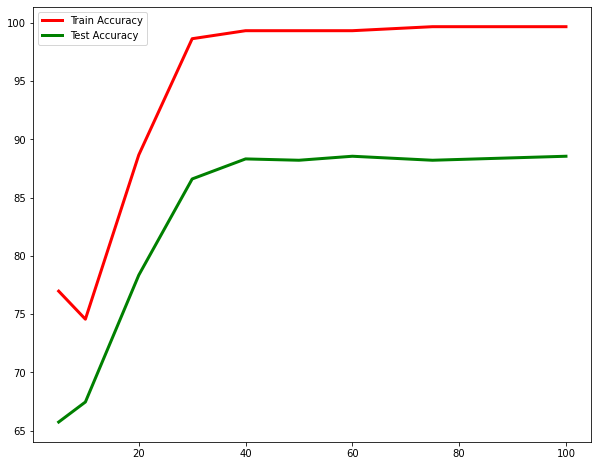

In [50]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.plot(num_epochs_used, train_accuracies, 'r-', lw=3, label='Train Accuracy')
ax.plot(num_epochs_used, test_accuracies, 'g-', lw=3, label='Test Accuracy')
ax.legend()

plt.show()

In [51]:
liar_test_accuracies = []
liar_train_accuracies = []

for num_epoch in num_epochs_used:
    test_accuracy, train_accuracy = trainAndTestSimpleModel('liar', num_epochs=num_epoch, print_epoch_mod=100)
    liar_test_accuracies.append(test_accuracy)
    liar_train_accuracies.append(train_accuracy)


Extracting tokens....

Extracting tokens....
Data shape for text:  (15052, 4893)
Epoch [1/5], Step [100/941], Loss: 0.7026
Epoch [1/5], Step [200/941], Loss: 0.6900
Epoch [1/5], Step [300/941], Loss: 0.6436
Epoch [1/5], Step [400/941], Loss: 0.6444
Epoch [1/5], Step [500/941], Loss: 0.6436
Epoch [1/5], Step [600/941], Loss: 0.6892
Epoch [1/5], Step [700/941], Loss: 0.7038
Epoch [1/5], Step [800/941], Loss: 0.6828
Epoch [1/5], Step [900/941], Loss: 0.6434
Epoch [2/5], Step [100/941], Loss: 0.7045
Epoch [2/5], Step [200/941], Loss: 0.6598
Epoch [2/5], Step [300/941], Loss: 0.6456
Epoch [2/5], Step [400/941], Loss: 0.6402
Epoch [2/5], Step [500/941], Loss: 0.6967
Epoch [2/5], Step [600/941], Loss: 0.6460
Epoch [2/5], Step [700/941], Loss: 0.7015
Epoch [2/5], Step [800/941], Loss: 0.6424
Epoch [2/5], Step [900/941], Loss: 0.6411
Epoch [3/5], Step [100/941], Loss: 0.6596
Epoch [3/5], Step [200/941], Loss: 0.6411
Epoch [3/5], Step [300/941], Loss: 0.6426
Epoch [3/5], Step [400/941], Loss: 0

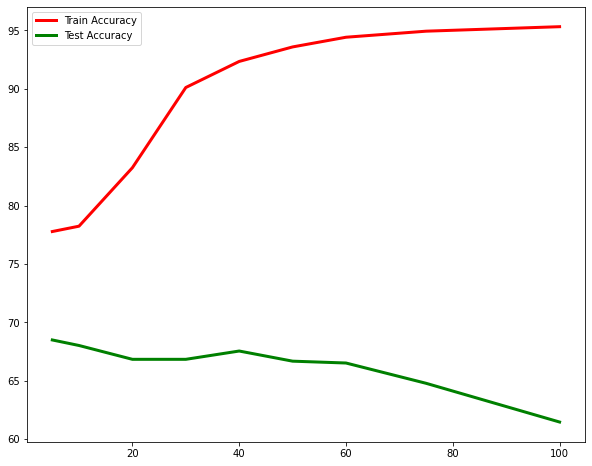

In [52]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.plot(num_epochs_used, liar_train_accuracies, 'r-', lw=3, label='Train Accuracy')
ax.plot(num_epochs_used, liar_test_accuracies, 'g-', lw=3, label='Test Accuracy')
ax.legend()

plt.show()

In [54]:
fnn_test_accuracies = []
fnn_train_accuracies = []

for num_epoch in num_epochs_used:
    test_accuracy, train_accuracy = trainAndTestSimpleModel('fnn', num_epochs=num_epoch, print_epoch_mod=100)
    fnn_test_accuracies.append(test_accuracy)
    fnn_train_accuracies.append(train_accuracy)


Extracting tokens....

Extracting tokens....
Data shape for text:  (15212, 4975)
Epoch [1/5], Step [100/951], Loss: 0.6441
Epoch [1/5], Step [200/951], Loss: 0.7013
Epoch [1/5], Step [300/951], Loss: 0.6404
Epoch [1/5], Step [400/951], Loss: 0.6629
Epoch [1/5], Step [500/951], Loss: 0.6409
Epoch [1/5], Step [600/951], Loss: 0.7022
Epoch [1/5], Step [700/951], Loss: 0.7062
Epoch [1/5], Step [800/951], Loss: 0.6384
Epoch [1/5], Step [900/951], Loss: 0.6465
Epoch [2/5], Step [100/951], Loss: 0.6731
Epoch [2/5], Step [200/951], Loss: 0.6813
Epoch [2/5], Step [300/951], Loss: 0.6395
Epoch [2/5], Step [400/951], Loss: 0.6453
Epoch [2/5], Step [500/951], Loss: 0.6659
Epoch [2/5], Step [600/951], Loss: 0.7005
Epoch [2/5], Step [700/951], Loss: 0.6431
Epoch [2/5], Step [800/951], Loss: 0.6393
Epoch [2/5], Step [900/951], Loss: 0.6400
Epoch [3/5], Step [100/951], Loss: 0.6426
Epoch [3/5], Step [200/951], Loss: 0.6468
Epoch [3/5], Step [300/951], Loss: 0.6413
Epoch [3/5], Step [400/951], Loss: 0

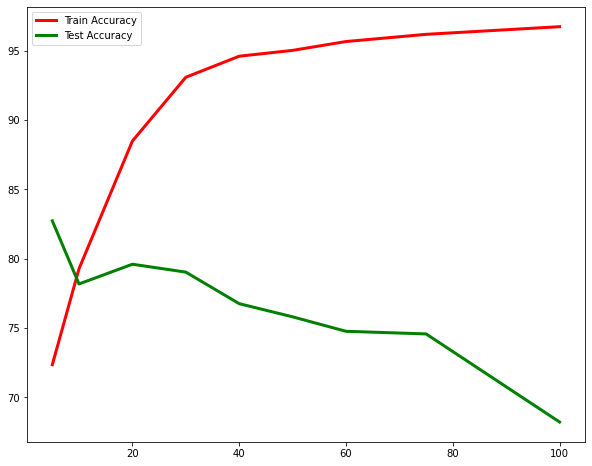

In [55]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.plot(num_epochs_used, fnn_train_accuracies, 'r-', lw=3, label='Train Accuracy')
ax.plot(num_epochs_used, fnn_test_accuracies, 'g-', lw=3, label='Test Accuracy')
ax.legend()

plt.show()